# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

In [2]:
import skimage.io
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import closing, square
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Brain image visualization

Let us first visualize the brain and try to get an idea how to solve the problem.

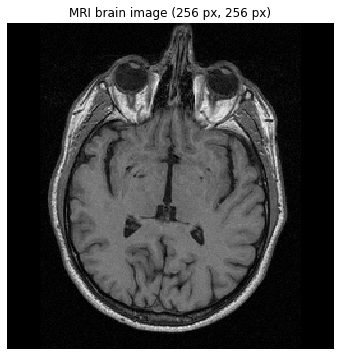

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
num_pixel = im_h*im_w

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

We can see that the objects on the image have more intensity than the background. To understand how gray levels are distributed over pixels, let us plot a histogram.

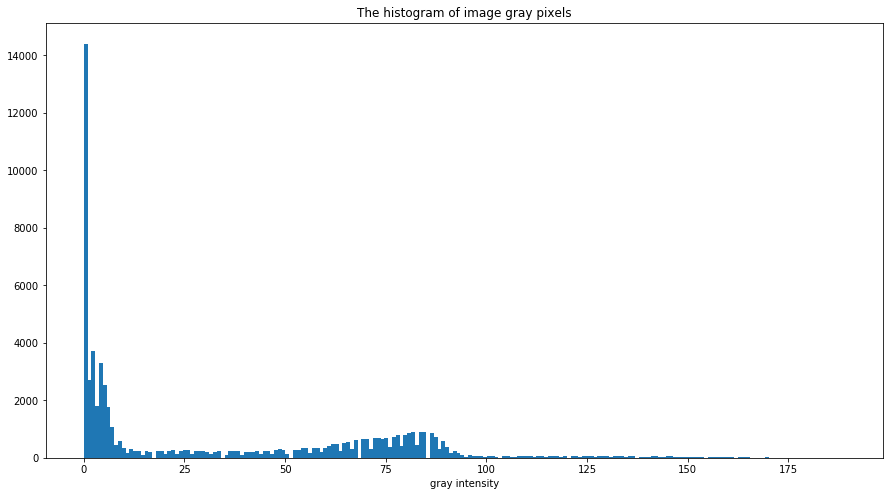

In [4]:
nbins = 200

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(brain_im.ravel(), bins=nbins)
ax.set_xlabel('gray intensity')
ax.set_title('The histogram of image gray pixels');

As you may see, we have a bimodal distribution and the two peaks correspond either to background (the peak near zero) or to the brain contours (around 75-80). In addition, we observe that we have noise which lead to the *skewness* of the peaks.

Using this information we can try different *region growing* methods to identify and label the objects which have the gray intensity higher than specific threshold. Moreover, to compute the size of the brain, we can use the fact that it is the biggest gray object.

Apart from that we will use *contour detection* methods to identify the edges of the objects.

### 1.2 Region growing

Let us first try manually different thresholds if they separate the objects from the background.

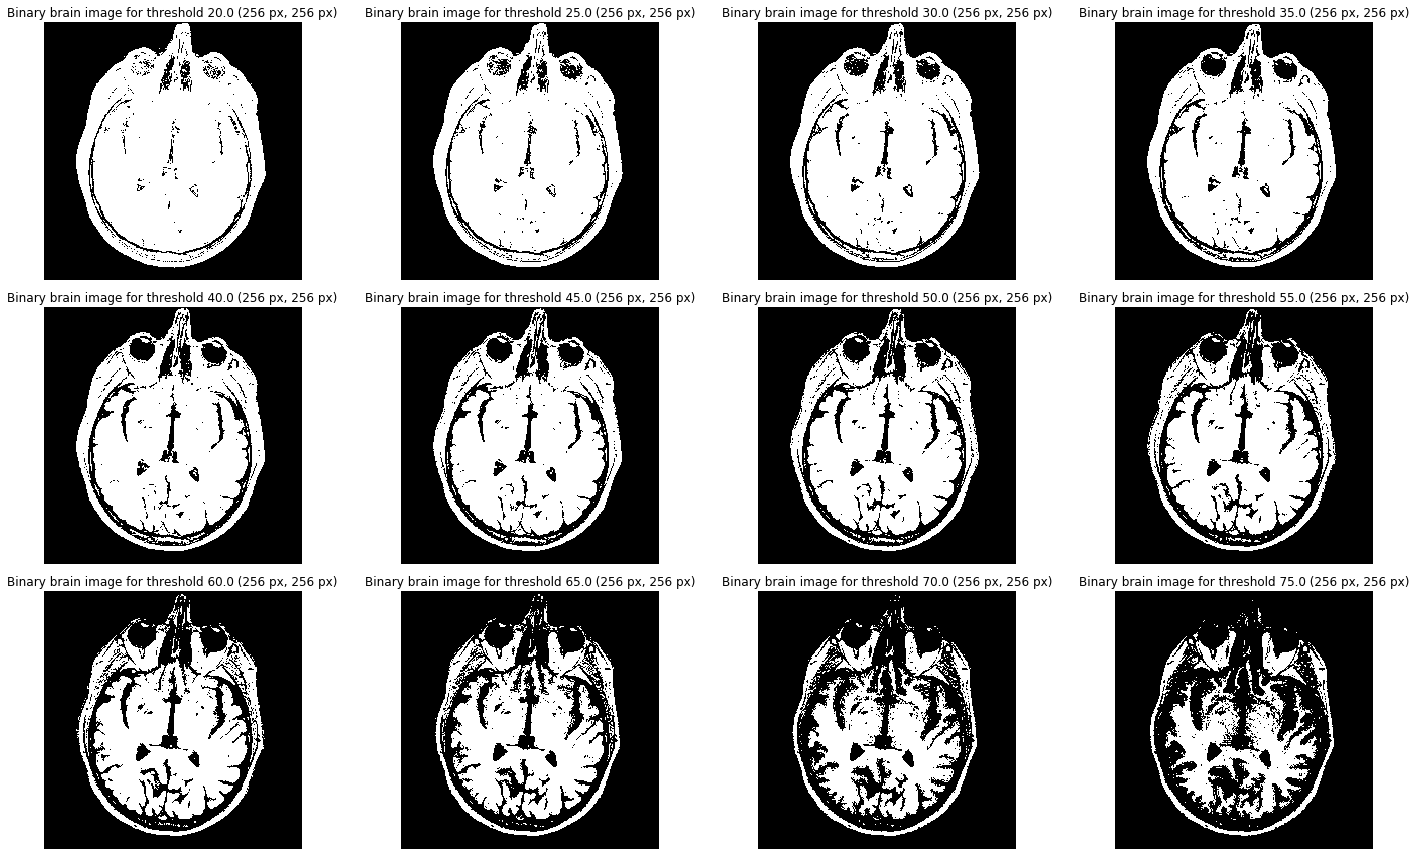

In [5]:
thresholds = np.linspace(20, 75, 12)

fig, ax = plt.subplots(3, 4, figsize=(20, 12))

for i, a in enumerate(ax.flatten()):
    brain_binary = brain_im > thresholds[i]
    a.imshow(brain_binary, cmap='gray')
    a.set_title('Binary brain image for threshold {} ({} px, {} px)'.format(thresholds[i], im_h, im_w))
    a.axis('off')
    
plt.tight_layout()

We can observe that the best threshold for the segmentation of the brain is around 60.

Now we should implement the region growing method to label the identified objects.

In [6]:
def get_neighbours(pixel):
    
    """
        Return 4 neighbours of the input pixel.
    """ 
    
    return [(pixel[0] + 1, pixel[1]), 
            (pixel[0] - 1, pixel[1]),
            (pixel[0], pixel[1] + 1),
            (pixel[0], pixel[1] - 1)]

def grow(pixel_to_start, mask, visited):
    
    """
        Return region starting from pixel_to_start. The region should correspond to mask.
    """
    
    stack = [pixel_to_start]
    region = [pixel_to_start]
    visited[pixel_to_start] = 1

    while len(stack):
        
        # Pick a pixel
        cur_pixel = stack.pop()

        pixels_to_check = get_neighbours(cur_pixel)
        
        # Check if neighbours are not visited and correspond to mask
        pixels_from_region = [pixel for pixel in pixels_to_check if mask[pixel] and not visited[pixel]]
        
        # Update containers
        stack.extend(pixels_from_region)
        for pixel in pixels_from_region:
            visited[pixel] = 1
        region.extend(pixels_from_region)
        
    return region
        
def region_growing(mask):
    
    """
        Region growing method that finds the connected objects in the image indicated by mask and labels them.
    """
    
    regions = []
    visited = np.zeros(mask.shape)
    
    while True: # Each iteration is aimed to process one region
        # Search pixels not attached for any processed region
        pixels_to_grow = mask * (1 - visited)
        
        # If all pixels from the mask are labeled, algorithm identified all objects
        if len(pixels_to_grow[pixels_to_grow > 0]) == 0:
            break
            
        X, Y = np.where(pixels_to_grow > 0)
        pixel_to_start = (X[0], Y[0]) # Pixel from unknown region
        
        region = grow(pixel_to_start, mask, visited)
        regions.append(region)
         
    return regions

In [7]:
%%time

manual_threshold = 60

brain_im_binary = brain_im > manual_threshold

regions = region_growing(brain_im_binary)
print(f"{len(regions)} shapes were found")

191 shapes were found
CPU times: user 168 ms, sys: 3.6 ms, total: 172 ms
Wall time: 171 ms


Let us check what is the biggest grown region.

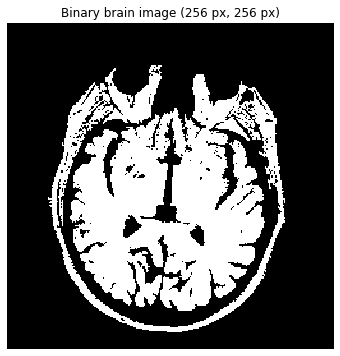

In [8]:
brain_region_coords = max(regions, key=len)

brain_mask = np.full(brain_im.shape, fill_value=False)
for coords in brain_region_coords:
    brain_mask[coords] = True

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_mask, cmap='gray')
ax.set_title('Binary brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

As we can see, this manual threshold probably is not the best after all.. Let us check optimal thresholds, that are implemented in skimage.

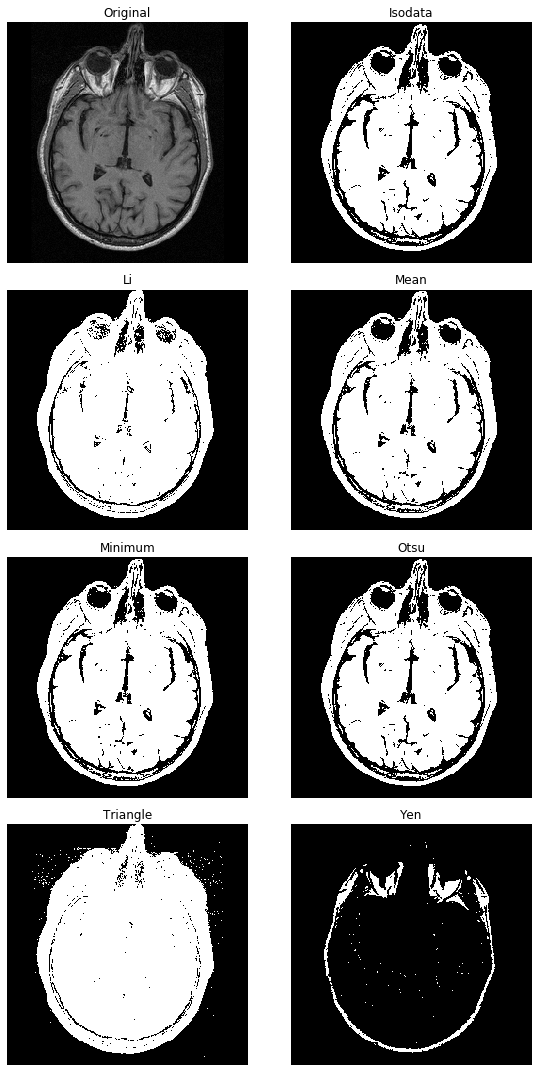

In [9]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(brain_im, figsize=(10, 15), verbose=False)
plt.tight_layout()

Some of them do the work much better!

Let us use the model, proposed by professor. We will use GaussianMixture model (implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)) to fit two Gaussians to the bimodal distribution to perform segmentation. 

/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


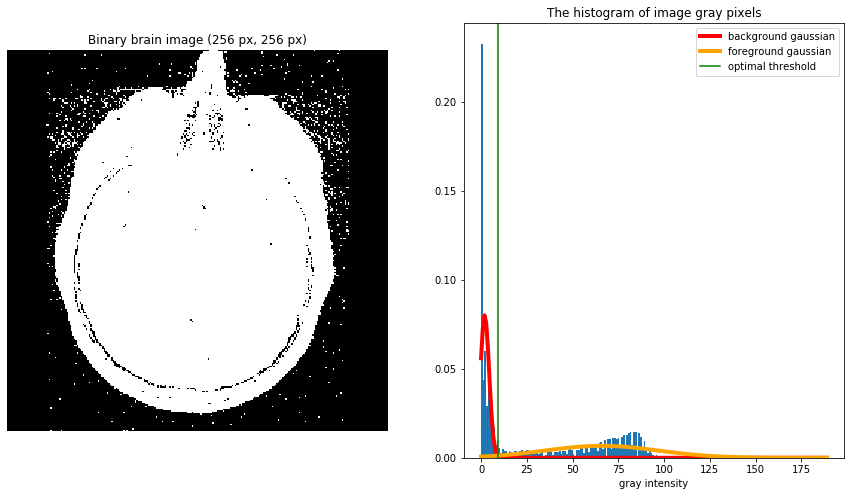

In [10]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import brentq

def find_optimal_threshold(gauss_1, gaus_2, mu):
    """
        Find the intensity level of the optimal threshold as the intersection
        between two gaussians. 
    """
    return brentq(lambda x: gauss_1(x) - gauss_2(x), min(mu), max(mu))

gaus_mix_segm = GaussianMixture(n_components=2, random_state=42, means_init=np.array([0, 80]).reshape(2, 1))
brain_im_binary = gaus_mix_segm.fit_predict(brain_im.reshape(num_pixel, 1)).reshape(im_h, im_w)

weights, mu, sigma = gaus_mix_segm.weights_.flatten(), gaus_mix_segm.means_.flatten(), np.sqrt(gaus_mix_segm.covariances_.flatten())
grid_x = np.linspace(brain_im.reshape(num_pixel, 1).min(), brain_im.reshape(num_pixel, 1).max(), 200)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].imshow(brain_im_binary, cmap='gray')
ax[0].set_title('Binary brain image ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].hist(brain_im.ravel(), bins=nbins, normed=True)
ax[1].set_xlabel('gray intensity')
ax[1].set_title('The histogram of image gray pixels')

gauss_1 = lambda x: norm.pdf(x, loc=mu[0], scale=sigma[0])
gauss_2 = lambda x: norm.pdf(x, loc=mu[1], scale=sigma[1])

optimal_threshold = find_optimal_threshold(gauss_1, gauss_2, mu)

gaussian_1 = weights[0]*gauss_1(grid_x)
gaussian_2 = weights[1]*gauss_2(grid_x)
ax[1].plot(grid_x, gaussian_1, lw=4, color='red', label='background gaussian')
ax[1].plot(grid_x, gaussian_2, lw=4, color='orange', label='foreground gaussian')
ax[1].axvline(optimal_threshold, color='green', label='optimal threshold')
ax[1].legend()

I already do not really like the obtained optimal threshold.

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [11]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


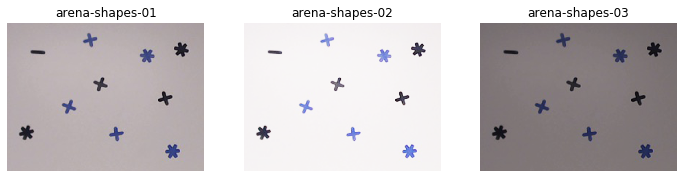

In [12]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

As first step we will try to distinguish foreground (shapes) from background. For that we will use contour based methods, namely Canny filter.

In [13]:
ind = 2 # Choose which image to process

In [14]:
image = images[ind]

In [15]:
grayscale = rgb2gray(image) * 255

In [16]:
edges = canny(grayscale/255.) # We will use popular Canny filter for edge detection

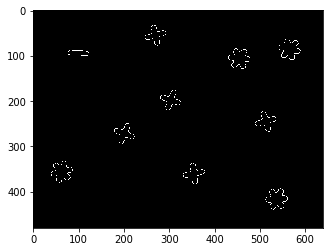

In [17]:
plt.imshow(edges, cmap="gray")
plt.show()

Great, now we have edges. Method worked relatively good, because source images have quite low level of noise.

Now we have to fill holes in shapes. For that we will use mathematical morphology methods. We will do closing with increasing size of structuring element till holes will be fully filled.

In [18]:
square_size = [5, 10, 20, 30, 40, 50]
mask_similarity_threshold = 0.999

shapes_mask = closing(edges, selem=square(square_size[0]))
for size in square_size[1:]:
    new_shapes_mask = closing(edges, selem=square(size))
    if np.sum(new_shapes_mask == shapes_mask) / shapes_mask.size > mask_similarity_threshold:
        break
    shapes_mask = new_shapes_mask

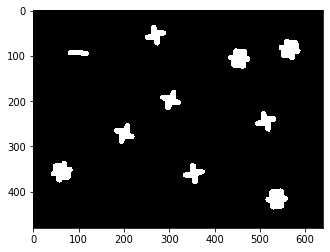

In [19]:
plt.imshow(shapes_mask, cmap="gray")
plt.show()

Now lets store pixels of each shape. For that we will use region growing method implemeneted in first part.

In [20]:
%time regions = region_growing(shapes_mask)
print(f"{len(regions)} shapes were found")

CPU times: user 64.7 ms, sys: 5.1 ms, total: 69.8 ms
Wall time: 68.5 ms
10 shapes were found


Now we can use all pixels from region to calculate mean value

In [21]:
region_colors = np.zeros(shape=(len(regions), 3))

for ind, region in enumerate(regions):
    pixel_values = np.array([image[pixel] for pixel in region])
    region_colors[ind, :] = pixel_values.mean(axis=0)
    
region_colors

array([[58.17824773, 60.11782477, 88.85498489],
       [36.35939553, 33.80617608, 39.32851511],
       [57.66644866, 59.76062786, 89.57030739],
       [39.12398374, 36.46341463, 41.17886179],
       [53.65575304, 50.03367633, 54.98409729],
       [37.33142857, 34.22666667, 38.15809524],
       [57.91713222, 60.19739292, 90.89199255],
       [36.91267236, 34.89954038, 40.01904137],
       [50.63235294, 53.1372549 , 86.69313725],
       [48.46991767, 52.96516783, 87.59784674]])

In [22]:
region_colors = np.zeros(shape=(len(regions), 3))

for ind, region in enumerate(regions):
    pixel_values = np.array([image[pixel] for pixel in region])
    region_colors[ind, :] = pixel_values.mean(axis=0)
    
region_colors

array([[58.17824773, 60.11782477, 88.85498489],
       [36.35939553, 33.80617608, 39.32851511],
       [57.66644866, 59.76062786, 89.57030739],
       [39.12398374, 36.46341463, 41.17886179],
       [53.65575304, 50.03367633, 54.98409729],
       [37.33142857, 34.22666667, 38.15809524],
       [57.91713222, 60.19739292, 90.89199255],
       [36.91267236, 34.89954038, 40.01904137],
       [50.63235294, 53.1372549 , 86.69313725],
       [48.46991767, 52.96516783, 87.59784674]])

We know that there are two colors: blue and gray. Gray color has relatively small std between color channels compared to blue color. Lets exploit that. 

In [23]:
region_std = [np.std(color) for color in region_colors]
region_std

[14.02635825743628,
 2.256615680448259,
 14.571123582462397,
 1.9303595988580713,
 2.092064523508547,
 1.6924359457855558,
 15.03588097155406,
 2.105852139628952,
 16.440640497250843,
 17.482132325284848]

In [24]:
region_std = [np.std(color) for color in region_colors]
region_std

[14.02635825743628,
 2.256615680448259,
 14.571123582462397,
 1.9303595988580713,
 2.092064523508547,
 1.6924359457855558,
 15.03588097155406,
 2.105852139628952,
 16.440640497250843,
 17.482132325284848]

In the current task, when the number of shapes of blue and gray is balanced, we can use the value of the mean standard deviation as a threshold. However, this approach will work worse when the number of figures of the same color is poorly balanced. For example, in the case of 10 grays and only 1 blue shape, our method is likely to mark some gray colors (with the highest std value) as blue.

In [25]:
mean_std = np.mean(region_std)
mean_std

8.763346352221781

In [26]:
region_labels = ["Blue" if region_std[region_ind] > mean_std else "Gray" for region_ind in range(len(regions))]
region_labels

['Blue',
 'Gray',
 'Blue',
 'Gray',
 'Gray',
 'Gray',
 'Blue',
 'Gray',
 'Blue',
 'Blue']

In [27]:
print(f"Now we can say that we have {region_labels.count('Blue')} blue and {region_labels.count('Gray')} gray shapes.")

Now we can say that we have 5 blue and 5 gray shapes.


Now, let's check that we labeled shapes correctly:

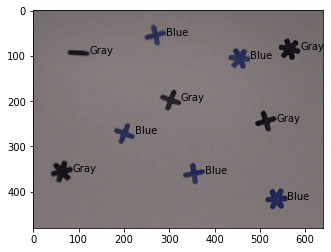

In [28]:
plt.imshow(image)
for ind in range(len(regions)):
    region_pixels = regions[ind]
    Y, X = zip(*region_pixels)
    plt.text(x=max(X), y = np.mean(Y), s=region_labels[ind])
plt.show()

Oui!

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

Our implementation of task 2.2 makes it easy to calculate total area of each color.

In [29]:
labels = ['Blue', "Gray"]
label_area = []

for label in labels:
    label_area.append(sum([len(regions[ind]) for ind in range(len(regions)) if region_labels[ind] == label]))
label_area

[6195, 5656]

In [30]:
print(f"There are {label_area[labels.index('Blue')]} blue and {label_area[labels.index('Gray')]} gray pixels.")

There are 6195 blue and 5656 gray pixels.
